# Booking Prediction

---

## Predictive modeling of customer bookings


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

In [2]:
df_original = pd.read_csv("Dataset/customer_booking.csv", encoding="ISO-8859-1")
df_original.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


Frist 5 rows of the Data

## Data Cleaning/Processing

In [3]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [4]:
df = df_original.copy()

In [5]:
# print unique Values
df_original["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [6]:
# convert Flight Day to numerical value
mapping_fd = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping_fd)

In [7]:
# print unique Values
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [8]:
# print unique Values
df["sales_channel"].unique()

array(['Internet', 'Mobile'], dtype=object)

In [9]:
# convert Sales Channel to numerical value
mapping_sc = {
    "Internet": 1,
    "Mobile": 2
}

df["sales_channel"] = df["sales_channel"].map(mapping_sc)

In [10]:
df["sales_channel"].unique()

array([1, 2], dtype=int64)

In [11]:
# print unique Values
df["trip_type"].unique()

array(['RoundTrip', 'CircleTrip', 'OneWay'], dtype=object)

In [12]:
# convert trip type to numerical value
mapping_tt = {
    "RoundTrip": 1,
    "CircleTrip": 2,
    "OneWay": 3,
}

df["trip_type"] = df["trip_type"].map(mapping_tt)

In [13]:
# print unique Values
df["trip_type"].unique()

array([1, 2, 3], dtype=int64)

In [14]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,1,1,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,1,1,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,1,1,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,1,1,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,1,1,68,22,15,3,AKLDEL,India,1,0,1,5.52,0


## Exploratory Data Analysis

In [15]:
# print total successful bookings
print("Booked flight (1 - yes, 0 - no)")
df_original["booking_complete"].value_counts()

Booked flight (1 - yes, 0 - no)


booking_complete
0    42522
1     7478
Name: count, dtype: int64

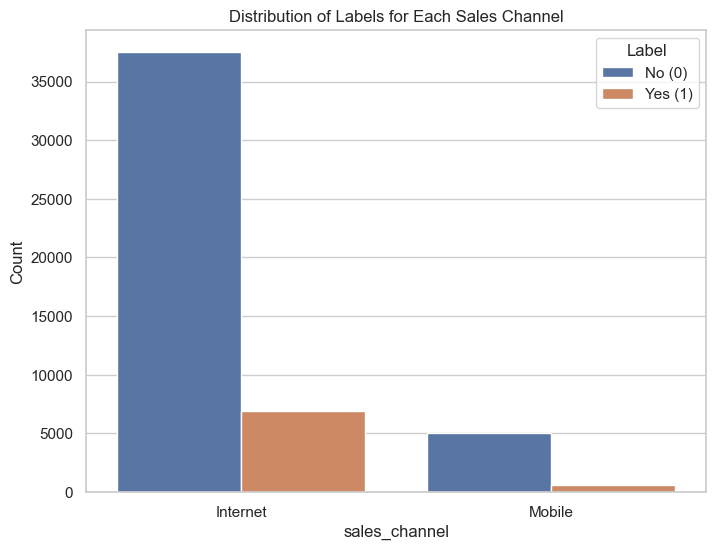

In [16]:
# plot all the bookings for sales channel
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(x="sales_channel", hue="booking_complete", data=df_original)

plt.xlabel("sales_channel")
plt.ylabel("Count")
plt.title("Distribution of Labels for Each Sales Channel")
plt.legend(title="Label", labels=["No (0)", "Yes (1)"])

Inference:
* we can see that around 6900 in 44382 people book flight after searching on Internet i.e. 15% success
* we can see that around 500 in 5618 people book flight after searching on Modile i.e. 8% success

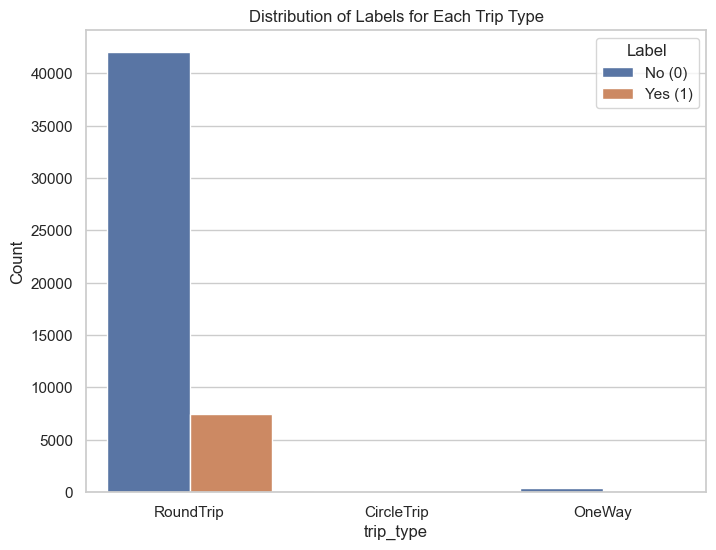

In [17]:
# plot all the bookings for sales channel
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(x="trip_type", hue="booking_complete", data=df_original)

plt.xlabel("trip_type")
plt.ylabel("Count")
plt.title("Distribution of Labels for Each Trip Type")
plt.legend(title="Label", labels=["No (0)", "Yes (1)"])

Inference:
* we can see that around 7500 in 49,497 people book round trip after searching
* rest of the types have little to no bookings w.r.t round trip

In [18]:
# get idea about the purchase_lead range (0-50, 50-100, ...)
def range_purchase_lead(x):
    if x >= 0 and x < 51:
        return '0-50'
    elif x >= 51 and x < 100:
        return '51-100'
    elif x >= 101 and x < 150:
        return '101-150'
    elif x >= 151 and x < 200:
        return '151-200'
    elif x >= 201 and x < 250:
        return '201-250'
    else:
        return '250+'

In [19]:
df_original['range_purchase_lead'] = df_original['purchase_lead'].apply(range_purchase_lead)

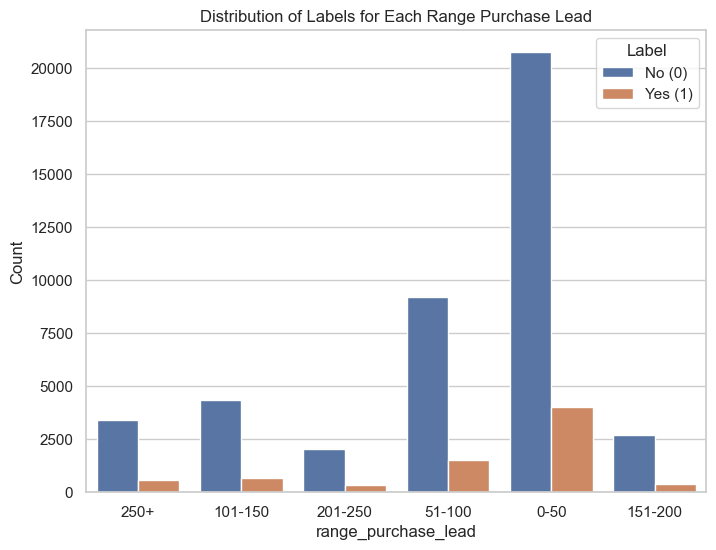

In [20]:
# plot all the bookings for range purchase lead
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(x="range_purchase_lead", hue="booking_complete", data=df_original)

plt.xlabel("range_purchase_lead")
plt.ylabel("Count")
plt.title("Distribution of Labels for Each Range Purchase Lead")
plt.legend(title="Label", labels=["No (0)", "Yes (1)"])

Inference:
* Basted on the plot above we can observe that maximum booking search is for the travel date range "0-50"
* The Booking success percent is similar accross the plot 
* Also, it we can see that there are more number of bookings in 0-100 range over all

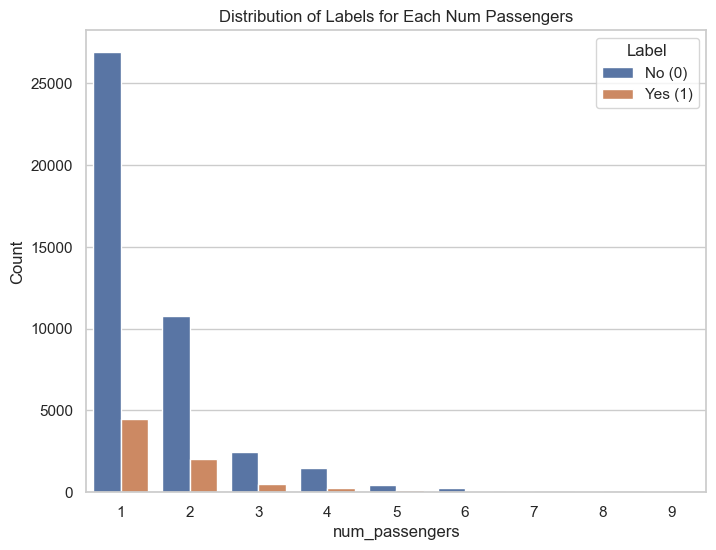

In [21]:
# Plot to see if number of passengers have any impact on booking
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(x="num_passengers", hue="booking_complete", data=df_original)

plt.xlabel("num_passengers")
plt.ylabel("Count")
plt.title("Distribution of Labels for Each Num Passengers")
plt.legend(title="Label", labels=["No (0)", "Yes (1)"])

Inference:
* Based on the plot we can see that more searches are for less number of passengers (1

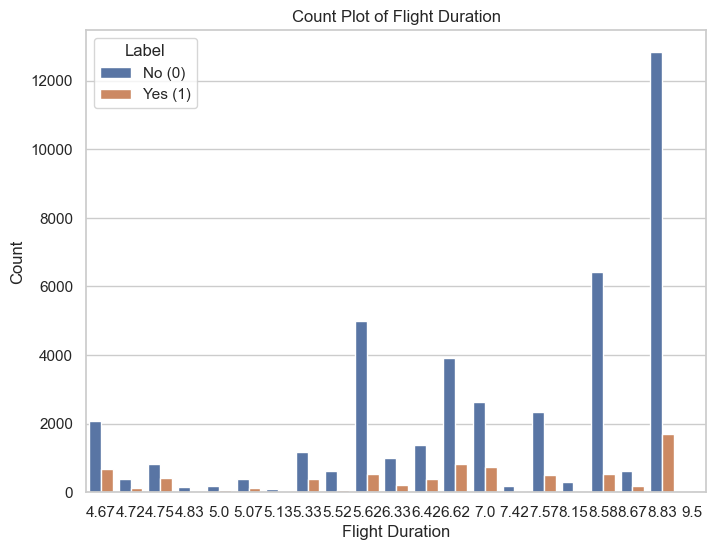

In [22]:
# Plot to see if number of passengers have any impact on booking
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(x='flight_duration', hue="booking_complete", data=df_original)

plt.xlabel('Flight Duration')
plt.ylabel('Count')
plt.title('Count Plot of Flight Duration')
plt.legend(title="Label", labels=["No (0)", "Yes (1)"])
plt.show()

## Feature Selection

In [23]:
# split teh data into X, y
X, y = df.drop(["booking_complete", "booking_origin", "route"], axis=1) ,df['booking_complete']

### Chi2 selection

In [24]:
# Chi-Square
selector_chi2 = SelectKBest(chi2, k=5)
X_chi2 = selector_chi2.fit_transform(X, y)

In [25]:
selected_features_chi2 = X.columns[selector_chi2.get_support()]
selected_features_chi2

Index(['purchase_lead', 'length_of_stay', 'wants_extra_baggage',
       'wants_preferred_seat', 'flight_duration'],
      dtype='object')

Inference:
* Best Features as per chi2 are 'purchase_lead', 'length_of_stay', 'wants_extra_baggage',  'wants_preferred_seat', 'flight_duration'

### Ranfom Forest Classifier selection

In [26]:
# RandomForestClassifier
selector_rf = RandomForestClassifier(n_estimators=100)
selector_rf.fit(X, y)
feature_importances_rf = selector_rf.feature_importances_
selected_features_rf = X.columns[feature_importances_rf > 0.1]
selected_features_rf

Index(['purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day',
       'flight_duration'],
      dtype='object')

Inference:
* Best Features as per Ranfom Forest 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day',  'flight_duration'

### Mutual Information selection

In [27]:
# mutual_info_classif
selector_mi = SelectKBest(mutual_info_classif, k=5)
X_mi = selector_mi.fit_transform(X, y)

In [28]:
selected_features_mi = X.columns[selector_mi.get_support()]
selected_features_mi

Index(['sales_channel', 'trip_type', 'length_of_stay', 'wants_extra_baggage',
       'flight_duration'],
      dtype='object')

Inference:
* Best Features as per Mutual Information 'sales_channel', 'trip_type', 'length_of_stay', 'wants_extra_baggage',  'flight_duration'

### Logistic Regression

In [29]:
# LogisticRegression
selector_lr = LogisticRegression(penalty='l1', solver='liblinear')
selector_lr.fit(X, y)

selected_features_lr = X.columns[np.logical_or(selector_lr.coef_[0] > 0.1, selector_lr.coef_[0] < -0.1)]
selected_features_lr

Index(['sales_channel', 'trip_type', 'wants_extra_baggage',
       'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration'],
      dtype='object')

Inference:
* Best Features as per Logistic Regression 'sales_channel', 'trip_type', 'wants_extra_baggage',  'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration'

**Important Features**

Based on the above methods the important features are "sales_channel", "purchase_lead", "length_of_stay", "flight_duration", "trip_type", "flight_hour", "flight_day".

In [30]:
X_new = X[["sales_channel", "purchase_lead", "length_of_stay", "flight_duration", "trip_type", "flight_hour", "flight_day"]]

## Model Training

### Random Forest Classifier

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=123)

In [32]:
# Ranfom forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [33]:
# Fit the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [39]:
# Predict the test values
y_pred_rf = rf_model.predict(X_test)

In [40]:
# Model accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy: {accuracy_rf * 100:.2f}%')

Accuracy: 84.09%


### Logistic Regression Model

In [36]:
lr_model = LogisticRegression(random_state=42)

In [37]:
lr_model.fit(X_train, y_train)

D:\Forage\British Airways\BritishAirways_CustomerBookingPattern\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [41]:
y_pred_lr = lr_model.predict(X_test)

In [42]:
# Model accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f'Accuracy: {accuracy_lr * 100:.2f}%')

Accuracy: 85.05%
